## Machine Learning applied to identify Active Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Activity model.

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import pickle
import joblib
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

%matplotlib inline

In [3]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    
convert_mic('>64')

0

In [4]:
# Load meta data
meta_data = pd.read_excel('data/Cumulative_Peptide_data_PG1_v01.2.xlsx')
meta_data['MBC'] = [convert_mic(x) for x in meta_data['MBC']]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069
...,...,...,...,...
88,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367
89,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085
90,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292
91,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276


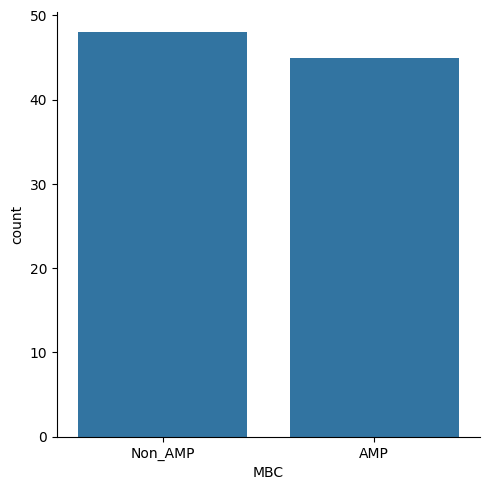

In [5]:
# Create the new target selectivity
sns.catplot(data=meta_data, x='MBC', kind='count')
plt.xticks([0,1], ['Non_AMP', 'AMP'])
plt.show()

## Load embedding

In [6]:
# # creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
data

,ID,Sequence,MBC,%Hemolysis,0,1,2,3,4,5,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
89,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
90,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
91,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [7]:
 # define target to evaluete the model
target = data["MBC"]

In [8]:
# define target
features = data.iloc[:, meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


In [9]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Train set shape: (74, 5120), Test set shape: (19, 5120)


## Selecting features by correlation only with the training set, to avoid any data leakage

In [10]:
def get_correlated_columns(df, target, threshold):
    # correlating train target  with train set
    corr_matrix = df.corrwith(target).abs().sort_values()

    # create a list of columns with high positive or negative correlation
    correlated_columns = []
    for column in corr_matrix.index:
        if (corr_matrix[column] >= threshold) & (column not in correlated_columns):
            correlated_columns.append(column)

    return(correlated_columns)

correlated_columns = get_correlated_columns(X_train, y_train, 0.3)
len(correlated_columns)

403

In [11]:
## filter train features and test by correlated columns with training
XX_train = X_train[correlated_columns]
XX_test = X_test[correlated_columns]
XX_train

,3631,4026,4066,1826,36,1767,2064,946,1461,971,...,4798,487,471,4208,5097,5040,2513,161,3928,298
65,0.224590,-0.181017,0.019545,-0.064964,0.155398,-0.083251,-0.078573,0.060894,0.135176,-0.003858,...,-0.029097,0.177040,0.130072,-0.146963,-0.087795,0.111696,0.025898,0.008033,-0.080181,0.005085
15,0.258698,-0.292690,0.148699,-0.028410,0.215603,-0.137803,0.032649,-0.081002,-0.040214,-0.097346,...,0.056988,0.193757,0.051790,-0.109553,-0.019315,0.040325,-0.059181,0.034861,-0.175179,0.070116
68,0.247156,-0.180406,0.046466,-0.015077,0.168196,-0.078284,-0.046413,0.044273,0.088894,0.040493,...,-0.012993,0.158517,0.126384,-0.142415,-0.080429,0.147653,0.007912,-0.008662,-0.038076,-0.003402
78,0.276134,-0.245234,0.187766,0.026071,0.100005,-0.054592,-0.003568,-0.085652,0.041215,-0.049524,...,0.029534,0.132943,0.185496,-0.108712,-0.068156,0.088899,-0.044196,-0.043395,-0.114422,0.021133
30,0.243169,-0.241218,0.069902,0.014592,0.164037,-0.002345,-0.033546,0.006789,0.025244,-0.036961,...,0.068468,0.152394,0.052741,-0.097367,-0.031445,0.035123,-0.014658,-0.014706,-0.171246,0.032627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0.213794,-0.203552,0.063490,0.001818,0.181617,-0.055392,-0.049133,0.027287,0.076497,-0.008704,...,0.016172,0.152772,0.085789,-0.121100,-0.012223,0.078034,-0.018210,0.017708,-0.088720,0.035312
60,0.113273,-0.167766,0.080620,-0.074886,0.092174,-0.037444,-0.091692,0.030662,0.147110,-0.022588,...,-0.022084,0.116958,0.112198,-0.146777,-0.087823,0.127181,-0.003842,-0.004091,-0.098466,-0.008927
71,0.245687,-0.191185,0.053689,-0.011010,0.179580,-0.071278,0.003873,0.038391,0.035693,-0.047713,...,0.019247,0.093586,0.114090,-0.093316,-0.045043,0.116584,-0.008730,0.038779,-0.075455,0.034221
14,0.235160,-0.223249,0.175795,-0.005861,0.198739,-0.107267,0.092756,-0.048212,0.014019,-0.182678,...,0.106824,0.225028,0.026538,0.017665,0.057679,-0.005950,-0.148193,0.022015,-0.134636,0.088755


## Run models

In [22]:
# create an empty dataframe to store results
results = pd.DataFrame()
results_cv = pd.DataFrame()

# create a list of classifiers to test
classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
]

# create a dictionary of hyperparameters to search over for each classifier
param_grids = [
    {'n_neighbors': [5, 10, 30, 50], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
    {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'max_iter': [-1], 'class_weight': [None, 'balanced']},
]

# create a list of names for the classifiers for printing results
model_names = ["KNN", 'GaussianNB', "SVM"]

# loop over the classifiers and hyperparameter grids
for name, clf, param_grid in zip(model_names, classifiers, param_grids):
    # create a GridSearchCV object with 5-fold cross-validation
    grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=10,)
    
    # fit the grid search object to the training data
    grid_search.fit(XX_train.values, y_train)
    
    # k-fold cross-validation on the training set
    accuracy_cv_scores = cross_val_score(grid_search, XX_train.values, y_train, cv=10, scoring='accuracy', n_jobs=10)
    recall_cv_scores = cross_val_score(grid_search, XX_train.values, y_train, cv=10, scoring='recall', n_jobs=10)
    precision_cv_scores = cross_val_score(grid_search, XX_train.values, y_train, cv=10, scoring='precision', n_jobs=10)
    f1_cv_scores = cross_val_score(grid_search, XX_train.values, y_train, cv=10, scoring='f1', n_jobs=10)


    # make predictions on the test data using the best model found by the grid search
    train_y_pred = grid_search.best_estimator_.predict(XX_train.values)
    test_y_pred = grid_search.best_estimator_.predict(XX_test.values)
    
    best_score = str(grid_search.best_score_.round(2))
    
    # evaluate the performance of the best model on the train data using accuracy score
    train_accuracy = metrics.accuracy_score(y_train, train_y_pred)
    train_recall = metrics.recall_score(y_train, train_y_pred)
    train_precision = metrics.precision_score(y_train, train_y_pred)
    train_f1_score = metrics.f1_score(y_train, train_y_pred)

    # evaluate the performance of the best model on the test data using accuracy score
    test_accuracy = metrics.accuracy_score(y_test, test_y_pred)
    test_recall = metrics.recall_score(y_test, test_y_pred)
    test_precision = metrics.precision_score(y_test, test_y_pred)
    test_f1_score = metrics.f1_score(y_test, test_y_pred)
    
    print(name)
    print(f'Train Accuracy: {train_accuracy.round(2)}, Train Recall: {train_recall.round(2)}, Train Precision: {train_precision.round(2)}')
    print(f'Test Accuracy: {test_accuracy.round(2)}, Test Recall: {test_recall.round(2)}, Test Precision: {test_precision.round(2)}')
    print()

    # Saving results
    res_dict = {}
    res_dict["embedding"] = 'esm2_15B'
    res_dict["embed_size"] = features.shape[1]
    res_dict["model"] = name

    res_dict["Train_Accuracy"] = train_accuracy.round(2)
    res_dict["Train_recall"] = train_recall.round(2)
    res_dict["Train_precision"] = train_precision.round(2)
    res_dict["Train_f1"] = train_f1_score.round(2)

    res_dict["Test_Accuracy"] = test_accuracy.round(2)
    res_dict["Test_recall"] = test_recall.round(2)
    res_dict["Test_precision"] = test_precision.round(2)
    res_dict["Test_f1"] = test_f1_score.round(2)


    res_dict['best_params'] = str(grid_search.best_params_)
 
    # updating data frame with results
    results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)
    
    # save results from cross-validation
    res_cv_dict = {
        "model": [name for i in range(10)],
        "Accuracy_CV_scores": accuracy_cv_scores,
        "Recall_CV_scores": recall_cv_scores,
        "Precision_CV_scores": precision_cv_scores,
        "F1_CV_scores": f1_cv_scores,
    }
    # updating data frame with results
    results_cv = pd.concat([results_cv, pd.DataFrame(res_cv_dict)]).reset_index(drop=True)

#results.to_excel('results/results_classification_MIC_new.xlsx')
#results_cv.to_excel('results_cv/results_cv_classification_MIC_new.xlsx')

KNN
Train Accuracy: 1.0, Train Recall: 1.0, Train Precision: 1.0
Test Accuracy: 0.68, Test Recall: 0.75, Test Precision: 0.75

GaussianNB
Train Accuracy: 0.76, Train Recall: 0.85, Train Precision: 0.68
Test Accuracy: 0.68, Test Recall: 0.75, Test Precision: 0.75

SVM
Train Accuracy: 0.84, Train Recall: 0.94, Train Precision: 0.76
Test Accuracy: 0.74, Test Recall: 0.75, Test Precision: 0.82



## Results Visualization

In [23]:
#results_cv = pd.read_excel('results/results_cv_classification_activity_v03.xlsx', index_col=0)
results_cv.groupby(['model']).mean()

,Accuracy_CV_scores,Recall_CV_scores,Precision_CV_scores,F1_CV_scores
model,,,,
GaussianNB,0.726786,0.816667,0.705000,0.725000
KNN,0.671429,0.833333,0.650000,0.687727
SVM,0.617857,0.683333,0.612857,0.585476


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


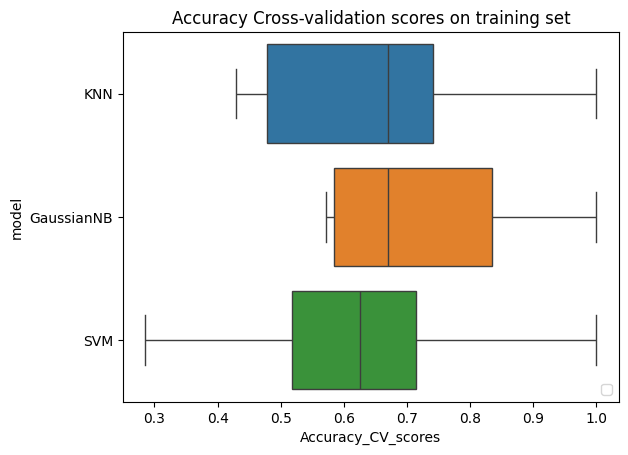

In [24]:
sns.boxplot(data=results_cv, y='model', x='Accuracy_CV_scores', hue='model', showfliers=False)
plt.title('Accuracy Cross-validation scores on training set')
plt.legend(loc='lower right')
plt.show()

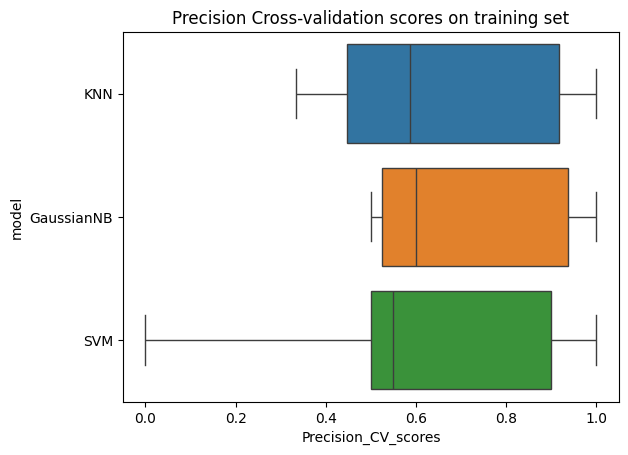

In [25]:
sns.boxplot(data=results_cv, y='model', x='Precision_CV_scores', hue='model', showfliers=False)
plt.title('Precision Cross-validation scores on training set')
plt.show()

## Train x Test

In [26]:
#results = pd.read_excel('results/results_classification_activity_v03.xlsx', index_col=0)
results

,embedding,embed_size,model,Train_Accuracy,Train_recall,Train_precision,Train_f1,Test_Accuracy,Test_recall,Test_precision,Test_f1,best_params
0,esm2_15B,5120,KNN,1.00,1.00,1.00,1.00,0.68,0.75,0.75,0.75,"{'n_neighbors': 30, 'p': 1, 'weights': 'distan..."
1,esm2_15B,5120,GaussianNB,0.76,0.85,0.68,0.76,0.68,0.75,0.75,0.75,{'var_smoothing': 1e-09}
2,esm2_15B,5120,SVM,0.84,0.94,0.76,0.84,0.74,0.75,0.82,0.78,"{'C': 10, 'class_weight': 'balanced', 'gamma':..."


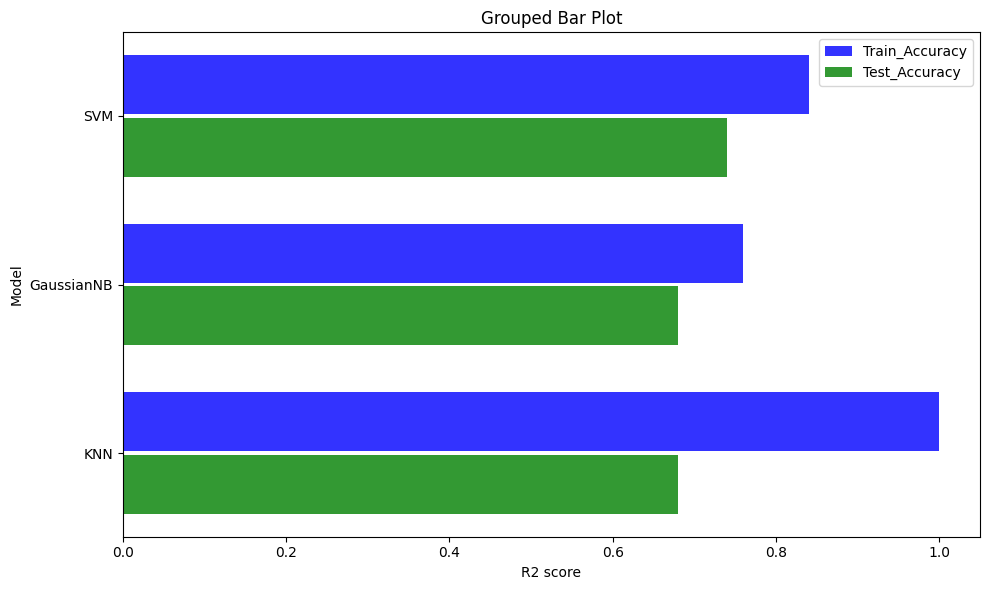

In [27]:
# Replace 'column1' and 'column2' with the names of the columns you want to plot
column1 = 'Train_Accuracy'
column2 = 'Test_Accuracy'

# Create a bar plot with two bars per group
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(results))
bar_height = 0.35
opacity = 0.8

# +/- 0.01 is to create a small space between bars
rects1 = ax.barh(y + bar_height/2 + 0.01, results[column1], bar_height, 
                 alpha=opacity, color='b', label=column1)
rects2 = ax.barh(y - bar_height/2 - 0.01, results[column2], bar_height,
                 alpha=opacity, color='g', label=column2)


# Add labels and legend
ax.set_ylabel('Model')
ax.set_xlabel('R2 score')
ax.set_title('Grouped Bar Plot')
ax.set_yticks(y)
ax.set_yticklabels(results['model'])
ax.legend()
plt.tight_layout()
plt.show()

To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation.   
If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting.   
In such cases, it may be necessary to adjust the hyperparameters of the model or to use a more complex kernel function.

## Fine Tunning Model with best hyperparameter found with Gridsearch

## Gaussian NB

In [ ]:
results.iloc[1, 11]

In [12]:
gnb = GaussianNB(
    var_smoothing= 1e-09,
    )

gnb.fit(XX_train, y_train)

# print Accuracy score
print(f'Accuracy score: {gnb.score(XX_train, y_train):.2f}')
print(f'Accuracy score: {gnb.score(XX_test, y_test):.2f}')

Accuracy score: 0.76
Accuracy score: 0.68


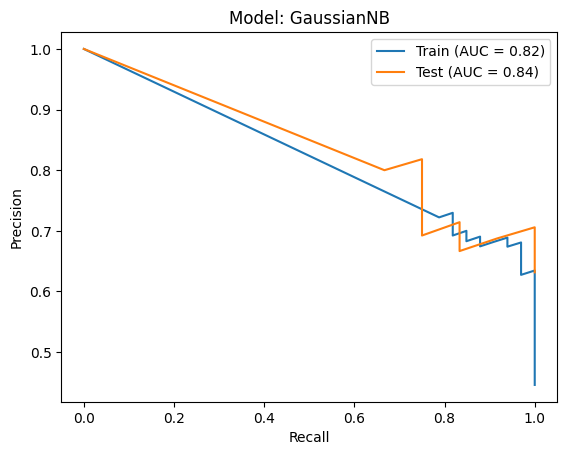

In [14]:
# Predict probabilities on the training and testing sets
y_train_proba = gnb.predict_proba(XX_train)[:, 1]
y_test_proba = gnb.predict_proba(XX_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.title('Model: GaussianNB')
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('results/precision_recall_curve_GaussianNB.png', dpi=600)
plt.show()

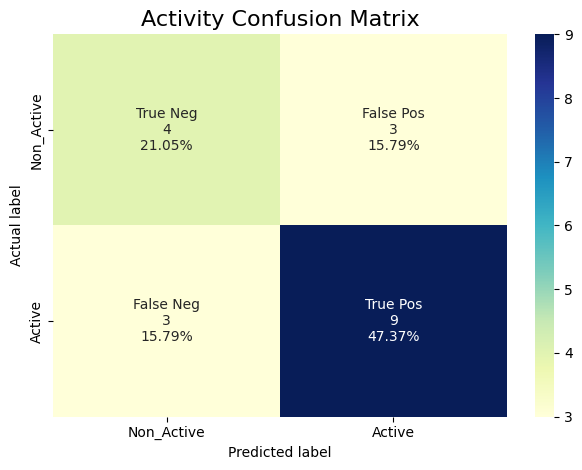

In [14]:
#confusion_matrix, 
y_pred = gnb.predict(XX_test)
conf_m = metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Active', 'Active']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Activity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [34]:
accuracy = metrics.accuracy_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.68
Recall: 0.75
Precision: 0.75
F1 Score: 0.75


## SVM

In [35]:
results.iloc[2, 11]

"{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1}"

In [36]:
svmR= SVC(C=10,
          class_weight= 'balanced',
          gamma='scale',
          kernel='rbf',
          max_iter=-1,
          probability=True)
         

# fit the model
svmR.fit(XX_train, y_train)

# print Accuracy score
print(f'Accuracy score: {svmR.score(XX_train, y_train):.2f}')
print(f'Accuracy score: {svmR.score(XX_test, y_test):.2f}')

Accuracy score: 0.84
Accuracy score: 0.74


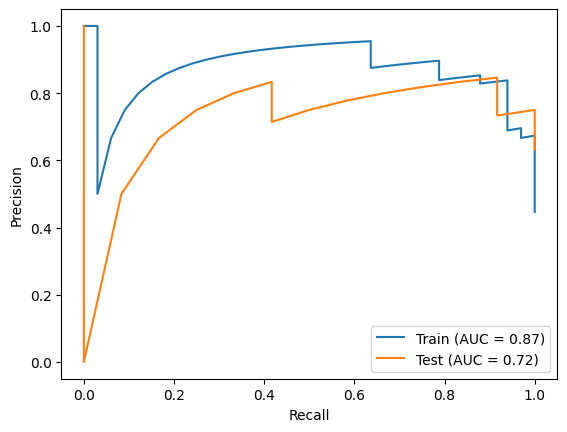

In [37]:
# Predict probabilities on the training and testing sets
y_train_proba = svmR.predict_proba(XX_train)[:, 1]
y_test_proba = svmR.predict_proba(XX_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

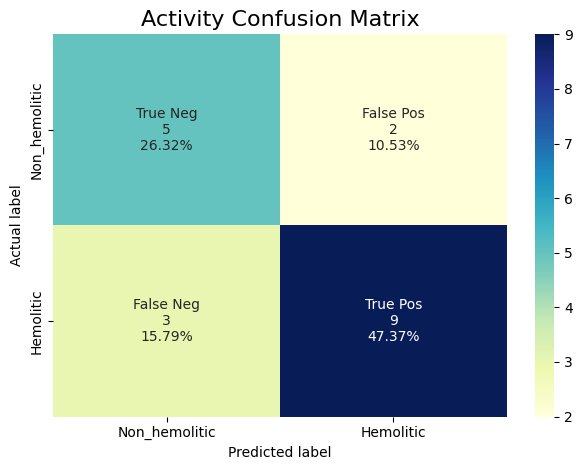

In [38]:
#confusion_matrix, 
y_pred = svmR.predict(XX_test)
conf_m = metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_hemolitic', 'Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Activity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Save the model and correlated columns

In [75]:
model = gnb

In [76]:
# save the model
joblib.dump(gnb, 'models/model_v01.2_GNB_esm2_15B_activity_classification_corr03.pkl')

#load the list from the file
with open('models/correlated_columns_v01.2_esm2_15B_activity_corr03.pkl', 'wb') as f:
    pickle.dump(correlated_columns, f)
